In [1]:
import torch
from torch import nn
from src.data.make_cifar10_dataset import CIFAR10, get_img_transformer
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import seaborn as sns
from src.models.cifar10_conv_model import Cifar10ConvModel
from sklearn import metrics
import numpy as np
import torch.nn.functional as nnf

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
test_dataset = CIFAR10(split="test", root='../data/processed', download=True,
                      transform=get_img_transformer())
test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=128)
calib_dataset = CIFAR10(split="calib", root='../data/processed', download=True,
                      transform=get_img_transformer())
calib_dataloader = torch.utils.data.DataLoader(
        calib_dataset, batch_size=128)
n_classes = len(set(test_dataset.targets))
classes = {index: name for name, index in test_dataset.class_to_idx.items()}
model = Cifar10ConvModel()
model.load_state_dict(torch.load("../models/trained_model.pt"))

Files already downloaded and verified
Files already downloaded and verified


<All keys matched successfully>

In [3]:
def get_dataset_smx_scores(set_type):
    data_loader = calib_dataloader if set_type == "calib" else test_dataloader
    prob_list = []
    with torch.no_grad():
        model.eval()
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            prob = nnf.softmax(output, dim=1)
            prob_list.append(prob)
        model.train()
    return np.concatenate(prob_list, axis=0)

In [4]:
def get_adaptive_predition_set(alpha):
    cal_smx = get_dataset_smx_scores("calib")
    val_smx = get_dataset_smx_scores("test")
    n=len(calib_dataset.targets)
    # get the index of descending sorted prob 
    cal_pi = cal_smx.argsort(1)[:,::-1]
    # use indices to sort and sum probabilities
    cal_srt = np.take_along_axis(cal_smx,cal_pi,axis=1).cumsum(axis=1)
    cal_scores = np.take_along_axis(cal_srt,cal_pi.argsort(axis=1),axis=1)[range(n),calib_dataset.targets]
    qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')
    # Deploy (output=list of length n, each element is tensor of classes)
    val_pi = val_smx.argsort(1)[:,::-1]; val_srt = np.take_along_axis(val_smx,val_pi,axis=1).cumsum(axis=1)
    prediction_sets = np.take_along_axis(val_srt <= qhat,val_pi.argsort(axis=1),axis=1)
    return prediction_sets

In [5]:
alpha_list = [0.05, 0.1, 0.15, 0.2]
asp_avg_set_size=[]
asp_coverage_list = []
for alpha in alpha_list:
    pred_set_length = []
    n_target_in_pred_set = 0
    for idx, p_set in enumerate(get_adaptive_predition_set(alpha)):
        pred_set_length.append(len(p_set[p_set==True]))
        pred_set_classes = np.array(p_set == True).nonzero()[0]
        is_target_in_pred_set = test_dataset.targets[idx] in pred_set_classes
        if is_target_in_pred_set: 
            n_target_in_pred_set+=1
    asp_avg_set_size.append(np.mean(pred_set_length))
    asp_coverage_list.append(n_target_in_pred_set/ len(test_dataset))

/var/folders/dw/gf2x93p50fdd3796cx4grnqw0000gn/T/ipykernel_42021/4036949097.py:10: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')


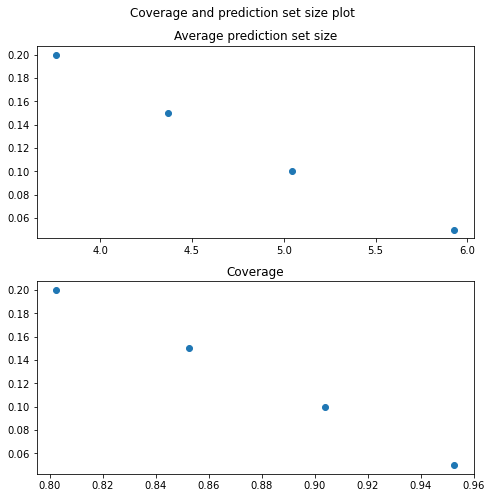

In [12]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(7, 7))
fig.suptitle('Coverage and prediction set size plot')
ax1.plot(asp_avg_set_size,alpha_list,'o')
ax1.set_title("Average prediction set size")

ax2.plot(asp_coverage_list,alpha_list,'o')
ax2.set_title("Coverage")
fig.tight_layout(pad=1.0)
plt.show()

In [7]:
def get_naive_predition_set(alpha):
    cal_smx = get_dataset_smx_scores("calib")
    val_smx = get_dataset_smx_scores("test")
    n=len(calib_dataset.targets)
    cal_scores = 1-cal_smx[np.arange(n),calib_dataset.targets]
    q_level = np.ceil((n+1)*(1-alpha))/n
    qhat = np.quantile(cal_scores, q_level, method='higher')
    prediction_sets = val_smx >= (1-qhat)
    return prediction_sets

In [8]:
alpha_list = [0.05, 0.1, 0.15, 0.2]
naive_avg_set_size=[]
naive_coverage_list = []
for alpha in alpha_list:
    pred_set_length = []
    n_target_in_pred_set = 0
    for idx, p_set in enumerate(get_naive_predition_set(alpha)):
        pred_set_length.append(len(p_set[p_set==True]))
        pred_set_classes = np.array(p_set == True).nonzero()[0]
        is_target_in_pred_set = test_dataset.targets[idx] in pred_set_classes
        if is_target_in_pred_set: 
            n_target_in_pred_set+=1
    naive_avg_set_size.append(np.mean(pred_set_length))
    naive_coverage_list.append(n_target_in_pred_set/ len(test_dataset))

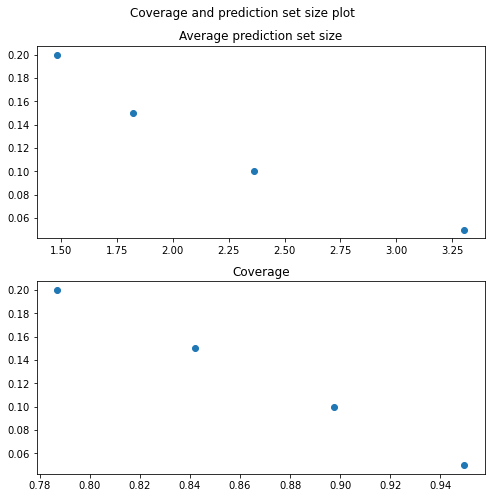

In [9]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(7, 7))
fig.suptitle('Coverage and prediction set size plot')
ax1.plot(naive_avg_set_size,alpha_list,'o')
ax1.set_title("Average prediction set size")

ax2.plot(naive_coverage_list,alpha_list,'o')
ax2.set_title("Coverage")
fig.tight_layout(pad=1.0)
plt.show()

In [10]:
naive_avg_set_size

[3.3049, 2.3657, 1.8224, 1.482]

In [2]:
import itertools
modelnames = ['ResNeXt101','ResNet152','ResNet101','ResNet50','ResNet18','DenseNet161','VGG16','Inception','ShuffleNet']
alphas = [0.05, 0.10]
predictors = ['Fixed','Naive', 'APS', 'RAPS']
params = list(itertools.product(modelnames, alphas, predictors))
params

[('ResNeXt101', 0.05, 'Fixed'),
 ('ResNeXt101', 0.05, 'Naive'),
 ('ResNeXt101', 0.05, 'APS'),
 ('ResNeXt101', 0.05, 'RAPS'),
 ('ResNeXt101', 0.1, 'Fixed'),
 ('ResNeXt101', 0.1, 'Naive'),
 ('ResNeXt101', 0.1, 'APS'),
 ('ResNeXt101', 0.1, 'RAPS'),
 ('ResNet152', 0.05, 'Fixed'),
 ('ResNet152', 0.05, 'Naive'),
 ('ResNet152', 0.05, 'APS'),
 ('ResNet152', 0.05, 'RAPS'),
 ('ResNet152', 0.1, 'Fixed'),
 ('ResNet152', 0.1, 'Naive'),
 ('ResNet152', 0.1, 'APS'),
 ('ResNet152', 0.1, 'RAPS'),
 ('ResNet101', 0.05, 'Fixed'),
 ('ResNet101', 0.05, 'Naive'),
 ('ResNet101', 0.05, 'APS'),
 ('ResNet101', 0.05, 'RAPS'),
 ('ResNet101', 0.1, 'Fixed'),
 ('ResNet101', 0.1, 'Naive'),
 ('ResNet101', 0.1, 'APS'),
 ('ResNet101', 0.1, 'RAPS'),
 ('ResNet50', 0.05, 'Fixed'),
 ('ResNet50', 0.05, 'Naive'),
 ('ResNet50', 0.05, 'APS'),
 ('ResNet50', 0.05, 'RAPS'),
 ('ResNet50', 0.1, 'Fixed'),
 ('ResNet50', 0.1, 'Naive'),
 ('ResNet50', 0.1, 'APS'),
 ('ResNet50', 0.1, 'RAPS'),
 ('ResNet18', 0.05, 'Fixed'),
 ('ResNet18', 0.05